In [ ]:
# Core libraries
import numpy as np
import pandas as pd
import cv2
import os
from pathlib import Path
import glob
import json

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Video, display, clear_output
import plotly.express as px
import plotly.graph_objects as go


# Utilities
import random
import warnings
from tqdm.notebook import tqdm
import time
from datetime import datetime
import requests
import urllib

# Set style and suppress warnings
plt.style.use('seaborn-v0_8')
warnings.filterwarnings('ignore')
sns.set_palette("husl")

print(" All libraries imported successfully!")

# =============================================================================
# Configuration & Paths
# =============================================================================

# Define Paths
PATHS = {
    'ou-mvlp': '/Users/caldwellwachira/Downloads/__Parent__/__Parent__/GEI',
    'mendeley': '/Users/caldwellwachira/Downloads/mendeley_dataset/Gun_Action_Recognition_Dataset',
    'output': './exploration_outputs',
    'pose_models': './pose_cache'
}

#Pose estimation configuration
POSE_CONFIG = {
    'input_width': 368,
    'input_height': 368,
    'threshold': 0.1,        # Lower threshold for silhouettes
    'model_name': 'pose_iter_440000.caffemodel',
    'proto_name': 'pose_deploy_linevec.prototxt'
}

OU_MVLP_CONFIG = {
    'image_extension': ['.jpg', '.png', '.jpeg'],
    'expected_format': 'silhouette',
    'typical_size': (88,128),
    'sample_count': 20
}
MENDELEY_CONFIG = {
    'video_extensions': ['.mp4', '.avi', '.mov'],
    'expected_format': 'rgb_video',
    'sample_count': 10, # videos to analyze
    'frames_per_video': 30,
    'categories': ['armed', 'unarmed'] # Expected categories
}

# OpenPose body parts (18 points)
POSE_POINTS = [
    "Nose", "Neck", "R-Sho", "R-Elb", "R-Wr", "L-Sho", 
    "L-Elb", "L-Wr", "R-Hip", "R-Knee", "R-Ank", "L-Hip", 
    "L-Knee", "L-Ank", "R-Eye", "L-Eye", "R-Ear", "L-Ear"
]

# Gait-relevant connections for visualization
POSE_PAIRS = [
    [1,2],[1,5],[2,3],[3,4],[5,6],[6,7], # Arms
    [1,8],[8,9],[9,10],[1,11],[11,12],[12,13], # Legs
    [1,0],[0,14],[14,16],[0,15],[15,17]
]

# Key gait landmarks
GAIT_LANDMARKS = {
    'shoulders': [2, 5],
    'elbows': [3, 6],
    'wrists': [4, 7],
    'hips': [8, 11],
    'knees': [9, 12],
    'ankles': [10, 13],
    'core': [1,8,11]
}
for path in PATHS.values():
    if path.startswith('./'):
        os.makedirs(path, exist_ok=True)


print(" Configuration loaded for:")
print(f"  - OU-MVLP (silhouettes): {PATHS['ou-mvlp']}")
print(f"  - Mendeley (RGB videos): {PATHS['mendeley']}")
print(f"  - Using 18-point OpenPose model")



# =============================================================================
# Helper Functions
# =============================================================================

def get_video_files(directory, extensions=['.mp4', '.avi', '.mov', '.MOV']):
    """Get all video files from directory"""
    if not os.path.exists(directory):
        print(f"Directory not found: {directory}")
        return []
    
    video_files = []
    for ext in extensions:
        pattern = os.path.join(directory, f"**/*{ext}")
        video_files.extend(glob.glob(pattern, recursive=True))
    return sorted(video_files)

def get_image_files(directory, extensions=['.jpg', '.jpeg', '.png', '.bmp', '.PNG', '.JPG']):
    """Get all image files from directory"""
    if not os.path.exists(directory):
        print(f"Directory not found: {directory}")
        return []
    
    image_files = []
    for ext in extensions:
        pattern = os.path.join(directory, f"**/*{ext}")
        image_files.extend(glob.glob(pattern, recursive=True))
    return sorted(image_files)

def get_video_info(video_path):
    """Extract basic video information"""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None
    
    info = {
        'path': video_path,
        'fps': cap.get(cv2.CAP_PROP_FPS),
        'frame_count': int(cap.get(cv2.CAP_PROP_FRAME_COUNT)),
        'width': int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
        'height': int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
        'duration': int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) / max(cap.get(cv2.CAP_PROP_FPS), 1),
        'size_mb': os.path.getsize(video_path) / (1024*1024)
    }
    cap.release()
    return info

def display_sample_frames(video_path, num_frames=5, figsize=(15, 3)):
    """Display sample frames from video"""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Could not open video: {video_path}")
        return
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames < num_frames:
        num_frames = max(1, total_frames)
    
    frame_indices = np.linspace(0, total_frames-1, num_frames, dtype=int)
    frames = []
    
    for frame_idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if ret:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame_rgb)
    
    cap.release()
    
    if not frames:
        print("No frames could be extracted")
        return
    
    # Display frames
    fig, axes = plt.subplots(1, len(frames), figsize=figsize)
    if len(frames) == 1:
        axes = [axes]
    
    for i, frame in enumerate(frames):
        axes[i].imshow(frame)
        axes[i].axis('off')
        axes[i].set_title(f'Frame {frame_indices[i]}')
    
    plt.tight_layout()
    plt.show()

def set_seed(seed=42):
    """Set random seeds for reproducibility"""
    np.random.seed(seed)
    random.seed(seed)

# Set random seed
set_seed(42)

print(" Helper functions loaded successfully!")

 All libraries imported successfully!
 Configuration loaded for:
  - OU-MVLP (silhouettes): /Users/caldwellwachira/Downloads/__Parent__/__Parent__/GEI
  - Mendeley (RGB videos): /Users/caldwellwachira/Downloads/mendeley_dataset
  - Using 18-point OpenPose model
 Helper functions loaded successfully!


In [25]:
def download_pose_models():
    """Download OpenPose models"""
    model_urls = {
        'prototxt': 'https://raw.githubusercontent.com/CMU-Perceptual-Computing-Lab/openpose/master/models/pose/body_25/pose_deploy.prototxt',
        'caffemodel': 'https://www.dropbox.com/s/3x0xambj2rkyrap/pose_iter_584000.caffemodel?dl=0'
    }

    model_paths = {
        'prototxt': os.path.join(PATHS['pose_models'], 'pose_deploy.prototxt'),
        'caffemodel': os.path.join(PATHS['pose_models'], 'pose_iter_584000.caffemodel')
    }

    # Download if not already present
    for model_type, url in model_urls.items():
        if not os.path.exists(model_paths[model_type]):
            print(f"Downloading {model_type} model...")
            try:
                urllib.request.urlretrieve(url, model_paths[model_type])
                print(f"{model_type} model downloaded successfully.")
            except Exception as e:
                print(f"Failed to download {model_type}: {e}")
                return None
        else:
            print(f"{model_type} model already exists.")

    return model_paths

def initialize_pose_detector():
    """Initialize OpenPose model"""
    model_paths = download_pose_models()
    if model_paths is None:
        return None
    try:
        # Load the network
        net = cv2.dnn.readNetFromCaffe(model_paths['prototxt'], model_paths['caffemodel'])
        print(" Pose detection network initialized successfully!")
        return net
    except Exception as e:
        print(f"Failed to initialize pose network {e}")
        return None
    
def detect_poses(image,net, threshold=0.1):
    """Detect pose keypoints in an image using OpenPose model"""
    if net is None:
        print("Pose network is not initialized.")
        return None

    # Prepare input
    height, width = image.shape[:2]
    blob = blob = cv2.dnn.blobFromImage(image, 1.0 / 255, (368, 368), (0, 0, 0), swapRB=False, crop=False)

    # Run detection
    net.setInput(blob)
    output = net.forward()

    # Extract keypoints
    points = []
    confidences = []

    for i in range(len(POSE_POINTS)):
        # Confidence map of corresponding body's part.
        prob_map = output[0, i, :, :]
            
        # Find global maxima of the prob_map.
        min_val, prob, min_loc, point = cv2.minMaxLoc(prob_map)
            
        # Scale the point to fit on the original image
        x = (width * point[0]) / output.shape[3]
        y = (height * point[1]) / output.shape[2]
            
        if prob > threshold:
            points.append((int(x), int(y)))
            confidences.append(prob)
        else:
            points.append(None)
            confidences.append(0.0)
        
    return points, confidences 

def visualize_pose(image, points, confidences, threshold=0.1):
    """Visualize detected pose on image"""
    img_copy = image.copy()

    # Draw keypoints
    for i, point in enumerate(points):
        if point is not None and confidences[i] > threshold:
            cv2.circle(img_copy, point, 5, (0, 255, 255), -1)
            cv2.putText(img_copy, POSE_POINTS[i], point, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    
    for pair in POSE_PAIRS:
        part_a = pair[0]
        part_b = pair[1]
        
        if (points[part_a] is not None and points[part_b] is not None and 
            confidences[part_a] > threshold and confidences[part_b] > threshold):
            cv2.line(img_copy, points[part_a], points[part_b], (0, 0, 255), 2)
        
    return img_copy

# Initialize pose detector
print("Initializing pose detection ...")
pose_net = initialize_pose_detector() 

                

Initializing pose detection ...
prototxt model already exists.
caffemodel model already exists.
 Pose detection network initialized successfully!


 Testing pose detection on your datasets...

Found 5 silhouette files
Testing pose detection on sample silhouettes...


[ERROR:0@4756.586] global net_impl.cpp:1169 getLayerShapesRecursively OPENCV/DNN: [Convolution]:(conv1_1): getMemoryShapes() throws exception. inputs=1 outputs=0/1 blobs=0
[ERROR:0@4756.586] global net_impl.cpp:1172 getLayerShapesRecursively     input[0] = [ 1 3 368 368 ]
[ERROR:0@4756.586] global net_impl.cpp:1182 getLayerShapesRecursively Exception message: OpenCV(4.12.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/dnn/src/layers/convolution_layer.cpp:368: error: (-215:Assertion failed) !blobs.empty() || inputs.size() > 1 in function 'getMemoryShapes'



error: OpenCV(4.12.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/dnn/src/layers/convolution_layer.cpp:368: error: (-215:Assertion failed) !blobs.empty() || inputs.size() > 1 in function 'getMemoryShapes'


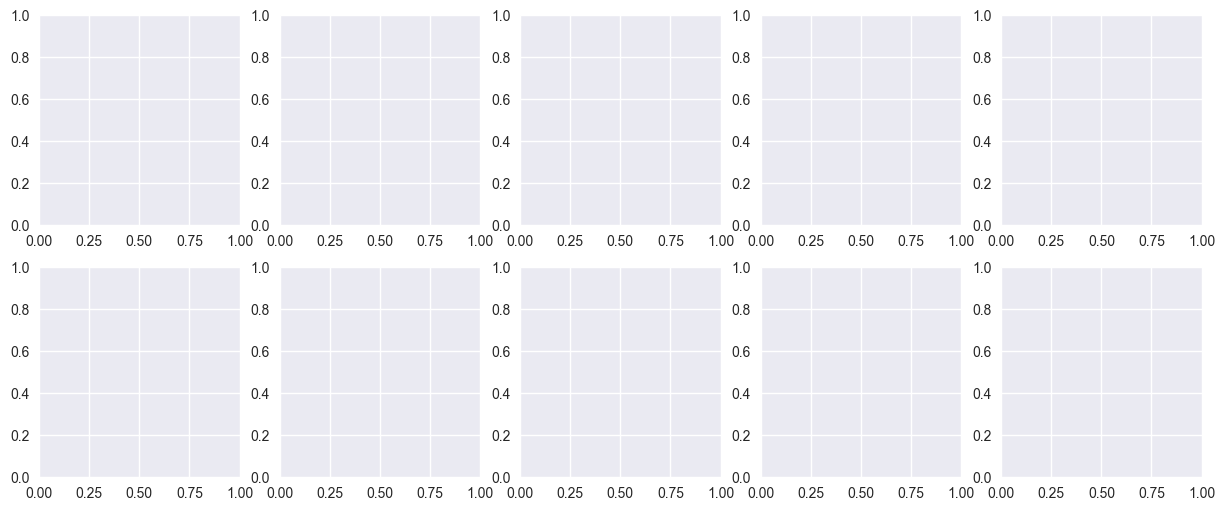

In [27]:
def test_pose_on_silhouette():
    """Test pose detection on OU-MVLP silhouette"""
    
    # Find a sample silhouette
    silhouette_files = get_image_files(PATHS['ou-mvlp'])[:5]  # Get first 5 images
    
    if not silhouette_files:
        print("❌ No silhouette images found in OU-MVLP path")
        return
    
    print(f"Found {len(silhouette_files)} silhouette files")
    print("Testing pose detection on sample silhouettes...")
    
    fig, axes = plt.subplots(2, len(silhouette_files), figsize=(15, 6))
    if len(silhouette_files) == 1:
        axes = axes.reshape(-1, 1)
    
    for i, img_path in enumerate(silhouette_files):
        # Load image
        img = cv2.imread(img_path)
        if img is None:
            continue
            
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Detect poses
        points, confidences = detect_poses(img, pose_net, threshold=0.05)  # Lower threshold for silhouettes
        
        # Visualize
        pose_img = visualize_pose(img_rgb, points, confidences, threshold=0.05)
        
        # Plot original and with pose
        axes[0, i].imshow(img_rgb)
        axes[0, i].set_title(f'Original {i+1}')
        axes[0, i].axis('off')
        
        axes[1, i].imshow(pose_img)
        axes[1, i].set_title(f'With Pose {i+1}')
        axes[1, i].axis('off')
        
        # Print detection stats
        detected_points = sum(1 for p in points if p is not None)
        avg_confidence = np.mean([c for c in confidences if c > 0.05])
        print(f"Image {i+1}: {detected_points}/18 points detected, avg confidence: {avg_confidence:.3f}")
    
    plt.tight_layout()
    plt.show()

def test_pose_on_video():
    """Test pose detection on Mendeley video"""
    # Find a sample video
    video_files = get_video_files(PATHS['mendeley'])[:3]  # Get first 3 videos


    if not video_files:
        print(" No video files found in Mendeley path")
        return
    
    print(f"Found {len(video_files)} video files")
    print("Testing pose detection on sample video frames...")
    
    for video_path in video_files:
        print(f"\nAnalyzing: {os.path.basename(video_path)}")
        
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            continue
    
        
        # Extract a few frames
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_indices = np.linspace(0, frame_count-1, num=5, dtype=int)
        
        fig, axes = plt.subplots(2, 5, figsize=(20, 8))

        for i, frame_idx in enumerate(frame_indices):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            if not ret:
                continue
            
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Detect poses
            points, confidences = detect_poses(frame, pose_net)

            pose_img = visualize_pose(img_rgb, points, confidences, threshold=0.05)
        
            # Plot original and with pose
            axes[0, i].imshow(img_rgb)
            axes[0, i].set_title(f'Original {i+1}')
            axes[0, i].axis('off')
            
            axes[1, i].imshow(pose_img)
            axes[1, i].set_title(f'With Pose {i+1}')
            axes[1, i].axis('off')
            
        cap.release()
        plt.tight_layout()
        plt.show()
        break

# Run tests if pose network is initialized
if pose_net is not None:
    print(" Testing pose detection on your datasets...\n")
    test_pose_on_silhouette()
    test_pose_on_video()





